In [32]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
num_classes = 100

In [2]:
# python hw4_bw.py  --resume --epoch 50

# Hyper Parameters
batch_size = 2

# Data Preparation

# note that mean and std is calculated channel-wise
# reference: https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/10
print("Data Preparation...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]),
])

train_dataset = torchvision.datasets.CIFAR100(root='../data', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR100(root='../data', train=False, download=False, transform=transform_test)

Data Preparation...
Files already downloaded and verified


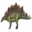

In [15]:
train_dataset[1][0]

In [27]:
a = transforms.RandomCrop(32, padding=1)

In [28]:
b = a(train_dataset[1][0])

In [29]:
b.size

(32, 32)

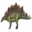

In [30]:
b

In [21]:
import torch
checkpoint = torch.load('./myresnet_checkpoint.pth.tar',map_location='cpu')

In [22]:
testing_accuracy_seq = checkpoint['testing_accuracy_seq']
training_accuracy_seq = checkpoint['training_accuracy_seq']

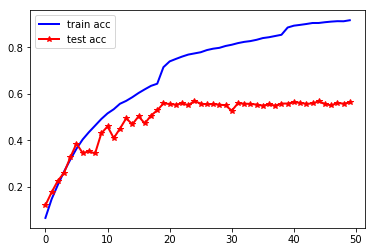

In [28]:
import matplotlib.pyplot as plt
plt.plot( training_accuracy_seq, '-',  color='blue', linewidth=2, label="train acc")
plt.plot( testing_accuracy_seq, '-*', color='red', linewidth=2, label="test acc")
plt.legend()
plt.show()

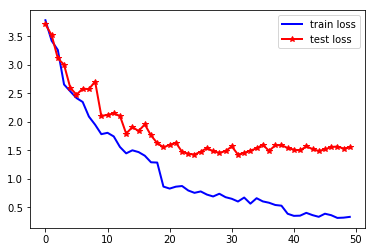

In [29]:
testing_loss_seq = checkpoint['testing_loss_seq']
training_loss_seq = checkpoint['training_loss_seq']
plt.plot( training_loss_seq, '-',  color='blue', linewidth=2, label="train loss")
plt.plot( testing_loss_seq, '-*', color='red', linewidth=2, label="test loss")
plt.legend()
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, padding=1, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=padding, stride=stride)
        self.batch_norm1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=padding, stride=1)
        self.batch_norm2 = nn.BatchNorm2d(num_features=out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(num_features=out_channels)
            )

    def forward(self, x):
        out = F.relu(self.batch_norm1(self.conv1(x)))
        out = self.batch_norm2(self.conv2(out))
        out += self.shortcut(x)
        return out

# test code
# x = np.random.randn(108).reshape((1,3,6,6))
# x = torch.from_numpy(x)
# model = ResidualBlock(in_channels=3, out_channels=32, stride=2)


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, padding=1, stride=1)
        self.batch_norm1 = nn.BatchNorm2d(num_features=32)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.layer1 = self.repeat_blocks(in_channels=32, out_channels=32,
                                         stride=1, padding=1, num_blocks=2)
        self.layer2 = self.repeat_blocks(in_channels=32, out_channels=64,
                                         num_blocks=4, stride=2, padding=1)
        self.layer3 = self.repeat_blocks(in_channels=64, out_channels=128,
                                         stride=2, padding=1, num_blocks=4)
        self.layer4 = self.repeat_blocks(in_channels=128, out_channels=256,
                                         stride=2, padding=1, num_blocks=2)
        self.linear = nn.Linear(1024, 100)

    def repeat_blocks(self, in_channels, out_channels, stride, padding, num_blocks):
        blocks = []
        for n in range(num_blocks):
            if n == 0:
                blocks.append(ResidualBlock(in_channels, out_channels, padding, stride))
            else:
                blocks.append(ResidualBlock(out_channels, out_channels, padding, stride=1))
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = F.relu(self.batch_norm1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.max_pool2d(out, kernel_size=2, stride=2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


if __name__ == "__main__":
    x = np.random.randn(6144).reshape((2, 3, 32, 32))
    x = torch.from_numpy(x)
    model = ResNet()
    model.forward(x.float()).shape
